In [25]:
import numpy as np
import itertools
from itertools import cycle, islice
import operator
import time
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
plt.rcParams.update({'legend.fontsize': 20})

Function to put brackets around left and right parts of the expression (only if the length of the part is more than 1).

In [2]:
def put_brackets(left_part, right_part, operator):
    if len(left_part)> 1 and len(right_part) > 1:
        return "("+left_part+")"+operator+"("+right_part+")"
    if len(left_part)> 1 and len(right_part) == 1:
        return "("+left_part+")"+operator+right_part
    if len(left_part)== 1 and len(right_part) > 1:
        return left_part+operator+"("+right_part+")"
    if len(left_part)== 1 and len(right_part) == 1:
        return left_part+operator+right_part

Minimizing recursive function

In [3]:
def minimize(expr):
    # base case
    if expr.isdigit():
        return int(expr), expr
    #variable to put final result. It is infinity in the beginning to be sure that at first comparison
    #between res and our expression result, res would be overwritten.
    res = np.inf
    #variable to put our final expression as string with brackets
    final_expr = ""
    # iterating over the expression, looking for operators
    for i in range(len(expr) - 1):
        if expr[i] == '+':
            #expression before operator
            left_expr = expr[:i]
            #expression after operator
            right_expr = expr[i + 1 :len(expr)]
            #computing their values by recursively calling the minimize function
            left_value, left_part = minimize(left_expr)
            right_value, right_part = minimize(right_expr)
            # if the sum of values is less than our minimal result before, this solution becomes new minimal result
            if left_value + right_value < res:
                res = left_value + right_value
                final_expr = put_brackets(left_part, right_part, expr[i])
        if expr[i] == '*':
            left_expr = expr[:i]
            right_expr = expr[i + 1 :len(expr)]
            left_value, left_part = minimize(left_expr)
            right_value, right_part = minimize(right_expr)
            if left_value * right_value < res:
                res = left_value * right_value
                final_expr = put_brackets(left_part, right_part, expr[i])
        if expr[i] == '-':
            left_expr = expr[:i]
            right_expr = expr[i + 1 :len(expr)]
            left_value, left_part = minimize(left_expr)
            right_value, right_part = minimize(right_expr)
            if left_value - right_value < res:
                res = left_value - right_value
                final_expr = put_brackets(left_part, right_part, expr[i])
        if expr[i] == '/':
            left_expr = expr[:i]
            right_expr = expr[i + 1 :len(expr)]
            left_value, left_part = minimize(left_expr)
            right_value, right_part = minimize(right_expr)
            #preventing division by zero
            if right_value != 0:
                if left_value / right_value < res:
                    res = left_value / right_value
                    final_expr = put_brackets(left_part, right_part, expr[i])
    return res, final_expr

In [4]:
minimize("1*3-2*5/1")

(-7.0, '1*(3-(2*(5/1)))')

Maximizing recursive function that works exactly as the minimizing one only the other way around.

In [5]:
def maximize (expr):
    if expr.isdigit():
        return int(expr), expr
    res = np.NINF
    final_expr = ""
    for i in range(len(expr) - 1):
        left_expr, right_expr = "", ""
        if expr[i] == '+':
            left_expr = expr[:i]
            right_expr = expr[i + 1 :len(expr)]
            left_value, left_part = maximize(left_expr)
            right_value, right_part = maximize(right_expr)
            if left_value + right_value > res:
                res = left_value + right_value
                final_expr = put_brackets(left_part, right_part, expr[i])
        if expr[i] == '*':
            left_expr = expr[:i]
            right_expr = expr[i + 1 :len(expr)]
            left_value, left_part = maximize(left_expr)
            right_value, right_part = maximize(right_expr)
            if left_value * right_value > res:
                res = left_value * right_value
                final_expr = put_brackets(left_part, right_part, expr[i])
        if expr[i] == '-':
            left_expr = expr[:i]
            right_expr = expr[i + 1 :len(expr)]
            left_value, left_part = maximize(left_expr)
            right_value, right_part = maximize(right_expr)
            if left_value - right_value > res:
                res = left_value - right_value
                final_expr = put_brackets(left_part, right_part, expr[i])
        if expr[i] == '/':
            left_expr = expr[:i]
            right_expr = expr[i + 1 :len(expr)]
            left_value, left_part = maximize(left_expr)
            right_value, right_part = maximize(right_expr)
            if right_value != 0:
                if left_value / right_value > res:
                    res = left_value / right_value
                    final_expr = put_brackets(left_part, right_part, expr[i])
    return res, final_expr

In [6]:
maximize('1*2*3*4-10')

(14, '1*((2*(3*4))-(10))')

Function that takes a list of numbers and list of operators and returns all possible combinations of operators that can be between these numbers with possible repetitions.

In [7]:
def put_operators(numbers, operators):
    oper_nr = len(numbers)-1
    opers = list(itertools.product(operators, repeat=oper_nr))
    return opers

In [8]:
put_operators([1, 2, 3, 4], ['*', '+'])

[('*', '*', '*'),
 ('*', '*', '+'),
 ('*', '+', '*'),
 ('*', '+', '+'),
 ('+', '*', '*'),
 ('+', '*', '+'),
 ('+', '+', '*'),
 ('+', '+', '+')]

From https://docs.python.org/2/library/itertools.html

In [9]:
def roundrobin(*iterables):
    "roundrobin('ABC', 'D', 'EF') --> A D E B F C"
    # Recipe credited to George Sakkis
    num_active = len(iterables)
    nexts = cycle(iter(it).__next__ for it in iterables)
    while num_active:
        try:
            for next in nexts:
                yield next()
        except StopIteration:
            # Remove the iterator we just exhausted from the cycle.
            num_active -= 1
            nexts = cycle(islice(nexts, num_active))

The final function that takes numbers, possible operators and maximize/minimize function as arguments and returns the maximal/minimal result and how it was achieved.

In [10]:
def put_operators_final(numbers, operators, func):
    results={}
    #possible operators' combinations with repetitions
    opers = put_operators(numbers, operators)
    for oper in opers:
        #creating a possible expression preserving numbers' order
        str_expr = ''.join(str(e) for e in roundrobin(numbers, oper))
        #saving expression as dictionary key with its result as value
        results[str_expr] = func(str_expr)
    if func == maximize:
        #looking for max result
        key = max(results, key=lambda k: results[k][0])
    if func == minimize:
        #looking for min result
        key = min(results, key=lambda k: results[k][0])
    return results[key]

In [11]:
put_operators_final([2, 1, 7, 1, 4, 3], ['*', '+', '-', '/'], maximize)

(315, '(2+1)*(7*((1+4)*3))')

In [12]:
put_operators_final([2, 1, 7, 1, 4, 3], ['*', '+', '-'], minimize)

(-231, '(2+1)*(7*(1-(4*3)))')

In [13]:
def measure_time(iterations, num_amount, num_min, num_max,  operators, func):
    results = []
    for i in range(iterations):
        random_numbers = [random.randint(num_min, num_max) for x in range(num_amount)]
        print(random_numbers)
        start_time = time.time()
        result = put_operators_final(random_numbers, operators, func)
        end_time = time.time()
        results.append(end_time-start_time)
    return results

In [14]:
iter5_num5_1_10_all_max = measure_time(iterations=5, num_amount=5, num_min=1, num_max=10, 
                                         operators=['*', '+', '-', '/'], func=maximize)
iter5_num6_1_10_all_max = measure_time(iterations=5, num_amount=6, num_min=1, num_max=10, 
                                         operators=['*', '+', '-', '/'], func=maximize)
iter5_num7_1_10_all_max = measure_time(iterations=5, num_amount=7, num_min=1, num_max=10, 
                                         operators=['*', '+', '-', '/'], func=maximize)
iter5_num8_1_10_all_max = measure_time(iterations=5, num_amount=8, num_min=1, num_max=10, 
                                         operators=['*', '+', '-', '/'], func=maximize)
iter5_num9_1_10_all_max = measure_time(iterations=5, num_amount=9, num_min=1, num_max=10, 
                                         operators=['*', '+', '-', '/'], func=maximize)

[8, 5, 7, 9, 2]
[4, 2, 1, 1, 5]
[4, 3, 4, 7, 8]
[1, 5, 10, 10, 7]
[3, 8, 8, 10, 2]
[5, 3, 5, 6, 2, 6]
[10, 2, 3, 3, 1, 2]
[5, 6, 6, 10, 9, 3]
[3, 8, 5, 1, 9, 10]
[5, 1, 7, 10, 1, 7]
[1, 8, 4, 5, 3, 3, 4]
[9, 2, 2, 2, 4, 6, 4]
[4, 5, 1, 4, 10, 10, 1]
[10, 1, 7, 5, 5, 7, 5]
[9, 1, 4, 7, 7, 10, 7]
[2, 10, 2, 1, 1, 2, 9, 1]
[4, 3, 9, 7, 10, 7, 7, 5]
[4, 5, 5, 10, 1, 2, 6, 8]
[9, 4, 10, 7, 8, 3, 3, 5]
[1, 1, 9, 4, 1, 7, 5, 7]
[10, 2, 7, 7, 9, 5, 3, 10, 2]
[4, 2, 10, 2, 5, 1, 6, 7, 5]
[1, 3, 6, 8, 9, 9, 4, 6, 8]
[2, 4, 6, 2, 6, 7, 10, 5, 7]
[1, 7, 10, 10, 10, 6, 6, 8, 8]


In [15]:
def average_time (measure_list):
    res = []
    for l in measure_list:
        res.append(np.average(l))
    return res

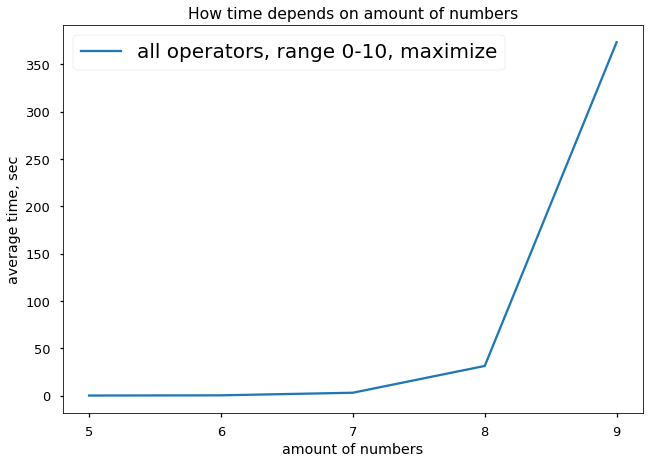

In [30]:
plt.plot(range(5, 10), average_time([iter5_num5_1_10_all_max, iter5_num6_1_10_all_max, iter5_num7_1_10_all_max, 
                                    iter5_num8_1_10_all_max, iter5_num9_1_10_all_max]), 
         label="all operators, range 0-10, maximize")
plt.ylabel("average time, sec")
plt.xlabel("amount of numbers")
plt.xticks([5, 6, 7, 8, 9])
plt.title("How time depends on amount of numbers")
plt.legend()
plt.show()

In [17]:
iter5_num7_1_10_1_max = measure_time(iterations=5, num_amount=7, num_min=1, num_max=10, 
                                         operators=['*'], func=maximize)
iter5_num7_1_10_2_max = measure_time(iterations=5, num_amount=7, num_min=1, num_max=10, 
                                         operators=['*', '+'], func=maximize)
iter5_num7_1_10_3_max = measure_time(iterations=5, num_amount=7, num_min=1, num_max=10, 
                                         operators=['*', '+', '-'], func=maximize)

[1, 2, 8, 8, 1, 9, 8]
[6, 8, 4, 5, 4, 1, 10]
[7, 8, 8, 5, 6, 4, 3]
[5, 6, 5, 2, 9, 9, 2]
[5, 2, 4, 2, 5, 5, 3]
[8, 9, 10, 6, 5, 1, 2]
[7, 1, 6, 8, 4, 9, 1]
[3, 8, 10, 1, 10, 5, 8]
[10, 7, 4, 6, 6, 2, 1]
[5, 10, 6, 4, 8, 4, 8]
[5, 7, 3, 1, 4, 5, 9]
[1, 8, 7, 1, 1, 9, 4]
[4, 9, 3, 1, 3, 7, 8]
[4, 8, 10, 10, 9, 4, 4]
[9, 10, 4, 9, 9, 8, 3]


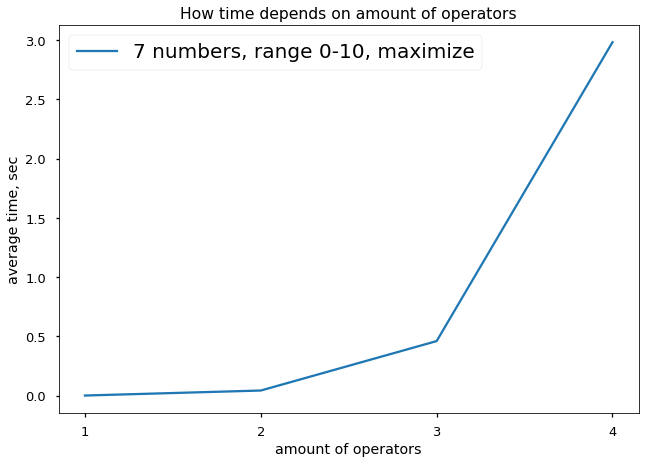

In [31]:
plt.plot([1, 2, 3, 4], average_time([iter5_num7_1_10_1_max, iter5_num7_1_10_2_max, iter5_num7_1_10_3_max, iter5_num7_1_10_all_max]),
        label = "7 numbers, range 0-10, maximize")
plt.ylabel("average time, sec")
plt.xlabel("amount of operators")
plt.xticks([1, 2, 3, 4])
plt.title("How time depends on amount of operators")
plt.legend()
plt.show()

In [19]:
iter5_num7_1_100_all_max = measure_time(iterations=5, num_amount=7, num_min=1, num_max=100, 
                                         operators=['*', '+', '-', '/'], func=maximize)
iter5_num7_1_1000_all_max = measure_time(iterations=5, num_amount=7, num_min=1, num_max=1000, 
                                         operators=['*', '+', '-', '/'], func=maximize)
iter5_num7_1_10000_all_max = measure_time(iterations=5, num_amount=7, num_min=1, num_max=10000, 
                                         operators=['*', '+', '-', '/'], func=maximize)

[52, 61, 90, 23, 65, 85, 79]
[23, 78, 97, 3, 38, 38, 7]
[8, 16, 16, 84, 17, 69, 26]
[45, 81, 56, 89, 23, 41, 55]
[54, 96, 76, 24, 71, 68, 77]
[396, 442, 938, 68, 664, 626, 731]
[400, 255, 677, 4, 9, 899, 644]
[80, 818, 843, 416, 595, 761, 120]
[380, 368, 937, 332, 134, 30, 97]
[9, 655, 786, 487, 726, 410, 988]
[4047, 5905, 4264, 6204, 6736, 4344, 1799]
[9067, 8918, 1443, 3993, 9328, 447, 4313]
[8267, 590, 8754, 6107, 8409, 9308, 8508]
[8560, 3768, 508, 8996, 9879, 6564, 1785]
[1356, 3221, 7989, 7104, 2644, 8528, 5349]


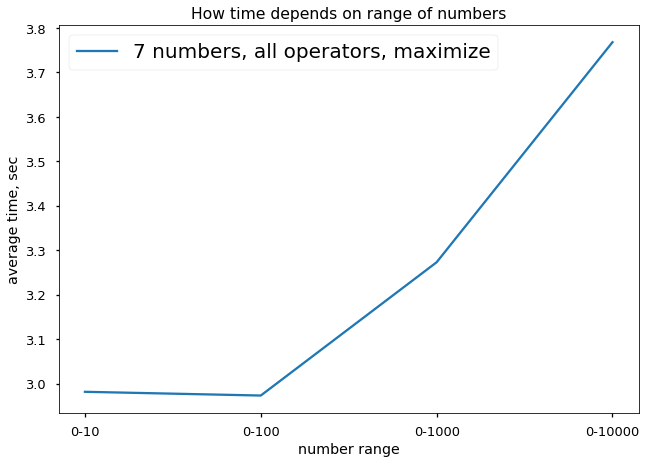

In [36]:
plt.plot([1, 2, 3, 4], average_time([iter5_num7_1_10_all_max, iter5_num7_1_100_all_max, iter5_num7_1_1000_all_max, iter5_num7_1_10000_all_max]),
        label = "7 numbers, all operators, maximize")
plt.ylabel("average time, sec")
plt.xlabel("number range")
my_names = ["0-10", "0-100", "0-1000", "0-10000"]
plt.xticks([1, 2, 3, 4], my_names)
plt.title("How time depends on range of numbers")
plt.legend()
plt.show()

In [21]:
iter5_num5_1_10_all_min = measure_time(iterations=5, num_amount=5, num_min=1, num_max=10, 
                                         operators=['*', '+', '-', '/'], func=minimize)
iter5_num6_1_10_all_min = measure_time(iterations=5, num_amount=6, num_min=1, num_max=10, 
                                         operators=['*', '+', '-', '/'], func=minimize)
iter5_num7_1_10_all_min = measure_time(iterations=5, num_amount=7, num_min=1, num_max=10, 
                                         operators=['*', '+', '-', '/'], func=minimize)
iter5_num8_1_10_all_min = measure_time(iterations=5, num_amount=8, num_min=1, num_max=10, 
                                         operators=['*', '+', '-', '/'], func=minimize)
iter5_num9_1_10_all_min = measure_time(iterations=5, num_amount=9, num_min=1, num_max=10, 
                                         operators=['*', '+', '-', '/'], func=minimize)

[5, 6, 3, 9, 9]
[3, 2, 4, 10, 8]
[7, 7, 10, 2, 7]
[9, 4, 3, 2, 4]
[7, 9, 5, 2, 1]
[9, 4, 5, 10, 1, 5]
[10, 7, 7, 10, 6, 1]
[7, 2, 7, 5, 4, 2]
[4, 2, 2, 6, 10, 10]
[2, 9, 4, 9, 2, 7]
[7, 8, 1, 10, 1, 9, 4]
[8, 6, 9, 6, 9, 7, 2]
[10, 1, 4, 10, 1, 3, 10]
[1, 2, 5, 3, 7, 5, 5]
[3, 1, 10, 8, 1, 10, 8]
[2, 9, 5, 3, 6, 10, 5, 1]
[6, 8, 1, 10, 1, 3, 2, 2]
[7, 7, 4, 7, 8, 1, 4, 4]
[9, 8, 1, 3, 3, 6, 9, 7]
[3, 8, 10, 9, 2, 5, 7, 5]
[2, 10, 9, 3, 4, 1, 8, 5, 7]
[3, 1, 3, 3, 2, 6, 4, 2, 3]
[9, 8, 2, 6, 2, 7, 7, 10, 8]
[7, 1, 2, 4, 8, 2, 6, 10, 5]
[8, 6, 8, 4, 6, 6, 10, 1, 6]


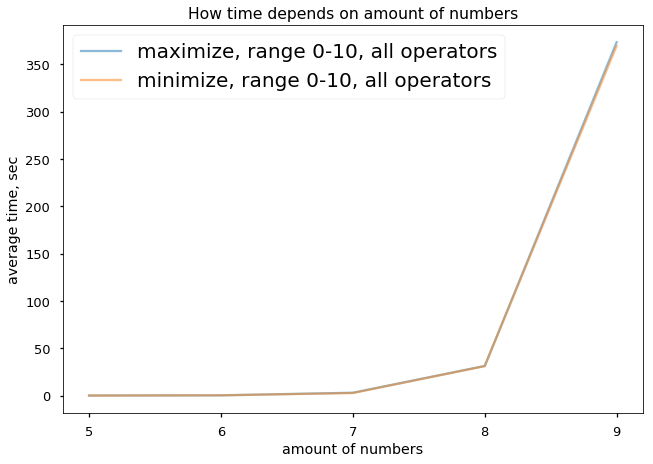

In [46]:
plt.plot(range(5, 10), average_time([iter5_num5_1_10_all_max, iter5_num6_1_10_all_max, iter5_num7_1_10_all_max, 
                                    iter5_num8_1_10_all_max, iter5_num9_1_10_all_max]), alpha=0.5, label='maximize, range 0-10, all operators')
plt.plot(range(5, 10), average_time([iter5_num5_1_10_all_min, iter5_num6_1_10_all_min, iter5_num7_1_10_all_min, 
                                    iter5_num8_1_10_all_min, iter5_num9_1_10_all_min]), alpha=0.5, label='minimize, range 0-10, all operators')
plt.ylabel("average time, sec")
plt.xlabel("amount of numbers")
plt.xticks([5, 6, 7, 8, 9])
plt.legend()
plt.title("How time depends on amount of numbers")
plt.show()